In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape,Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D,MaxPooling2D,Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras import initializers
import time

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape,x_test.shape
optimizer = Adam(0.0002, 0.5)

In [5]:
X=np.vstack((x_train,x_test))
y=np.hstack((y_train,y_test))

In [6]:
# Rescale -1 to 1
X = (X.astype(np.float32) - 127.5) / 127.5
X = np.expand_dims(X, axis=3)

In [7]:
randomDim=100

In [8]:
def make_gen(root=1):
    if root==1:
        model = Sequential()
        model.add(Dense(256, input_shape=(randomDim,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(28*28, activation='tanh'))
        model.add(Reshape((28,28,1)))
    else:
        model = keras.models.load_model(root)
    return model

In [9]:
def make_dis(root = 1):
    if root == 1:
        model = keras.models.Sequential()

        model.add(keras.layers.normalization.BatchNormalization(input_shape=(28, 28,1)))
        model.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
        model.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
        model.add(keras.layers.MaxPooling2D(2,2))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.normalization.BatchNormalization())
        model.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
        model.add(keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
        model.add(keras.layers.MaxPooling2D(2,2))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Flatten())

        model.add(keras.layers.Dense(256,activation="relu"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Dense(512,activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1,activation="sigmoid"))
    else:
        model = keras.models.load_model(root)
    return model

In [10]:
#dcgan
def gen_dcgan():
    model = Sequential([
        Dense(128*7*7, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Convolution2D(64, 5, 5, border_mode='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
    ])
    return model

In [11]:
#dcgan
def dis_dcgan():
    model=Sequential([
    Conv2D(64, 5, 5, subsample=(2,2), input_shape = (28,28,1), border_mode = 'same'),
    LeakyReLU(0.2),
    Dropout(0.3),
    Conv2D(128, 5, 5, subsample=(2,2), border_mode='same'),
    LeakyReLU(0.2),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation='sigmoid')
    ])
    return model


In [12]:
def plot_output():
    try_input = np.random.normal(size=(100,100))
    preds = gen.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

In [13]:
gen = gen_dcgan()
dis = dis_dcgan()

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
sgd = SGD(lr=0.01, momentum=0.9)

gen.compile(loss='binary_crossentropy', optimizer=adam,metrics=["accuracy"])
dis.compile(loss='binary_crossentropy', optimizer=adam,metrics=['accuracy'])

z = Input(shape=(100,))
img = gen(z)
valid = dis(img)

full_gan = Model(z, valid)
full_gan.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])

/home/stas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  if __name__ == '__main__':
/home/stas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="tanh", padding="same")`
  del sys.path[0]
/home/stas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.
/home/stas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2), padding="same")`
  import sys


In [14]:
def new_losses():
    
    global dis_loss
    global gen_loss
    global dis_acc
    global gen_acc
    
    dis_loss = []
    gen_loss = []
    dis_acc = []
    gen_acc = []
    
    return "ok"

In [15]:
def losses_wake(root = "./losses_array_gendisacc_gendisloss.npy"):
    a = np.load(root)
    
    global dis_loss
    global gen_loss
    global dis_acc
    global gen_acc
    
    dis_loss = a[3]
    gen_loss = a[2]
    dis_acc = a[1]
    gen_acc = a[0]
    
    return "ok"

In [16]:
def train(epoch=50,gen_size=14000,dis_ep=1,gen_ep=1,save_point=49,dis_root='dis.h5',gen_root='gen.h5',full_gan_root='full_gan.h5',verbose=2,loss_root="./losses_array",new_loss=True):
    global dis_loss
    global gen_loss
    global dis_acc
    global gen_acc
    
    if new_loss==True:
        new_losses()
    else:
        losses_wake(root=loss_root)
    
    y=np.array(range(140000))
    y[:70000] = 1
    y[70000:] = 0#генерим ответы
    valid_y = np.array([1] * gen_size)#
    
    for i in range(epoch):
        rand_int = np.random.randint(0,19)#случайное вычисление для повышения эфффективности
        #train dis
        dis.trainable=True#
        gen.trainable=False#фиксируем генератор
        gen_data=np.random.normal(size=(7000,100))#много рандомного шума"./losses_array_gendisacc_gendisloss.npy"
        generate_data=gen.predict(gen_data)#много генеренной даты

        buff_X=np.vstack((X[rand_int::10],generate_data))#Формируем обучающую выборку
        #Приколы с радом интом нужны шоб по всей выборке ходить, шо и не всю сразу в бач сувать и шоб все выборку заюзать
        
        if dis_ep>0:
            a=dis.fit(buff_X,y[rand_int::10],epochs=dis_ep,batch_size=1000,validation_split=0.15,verbose=verbose)#Собсна тренируем
            dis_loss+=a.history["val_loss"]
            dis_acc+=a.history["val_acc"]

        #train gen
        dis.trainable=False#
        gen.trainable=True#Фиксируем дискриминатор
        
        gen_data=np.random.normal(size=(gen_size,100))#
        
        if gen_ep>0:
            a=full_gan.fit(gen_data,valid_y,epochs=gen_ep,batch_size=1000,validation_split=0.15,verbose=verbose)#
            gen_loss+=a.history["val_loss"]
            gen_acc+=a.history["val_acc"]

        if i%100==save_point:#сейвим модели каждую Save_point эпоху
            dis.save(dis_root)
            gen.save(gen_root)
            full_gan.save(full_gan_root)
            ok=np.array((gen_acc,dis_acc,gen_loss,dis_loss))
            np.save(loss_root,ok)#сейвим лоссы
            
        if (i+1)%25==0:
            print("Master, I did {} epoches".format(i+1))
        
    return "lol"

In [17]:
train(epoch=1000, verbose=0, dis_root="new_leaky_dcgan_dis.h5", gen_root="new_leaky_dcgan_gen.h5", full_gan_root="new_leaky_dcgan_full.h5", loss_root="./new_gans_losses")

Master, I did 25 epoches
Master, I did 50 epoches
Master, I did 75 epoches
Master, I did 100 epoches
Master, I did 125 epoches
Master, I did 150 epoches
Master, I did 175 epoches
Master, I did 200 epoches
Master, I did 225 epoches
Master, I did 250 epoches
Master, I did 275 epoches
Master, I did 300 epoches
Master, I did 325 epoches
Master, I did 350 epoches
Master, I did 375 epoches
Master, I did 400 epoches
Master, I did 425 epoches
Master, I did 450 epoches
Master, I did 475 epoches
Master, I did 500 epoches
Master, I did 525 epoches
Master, I did 550 epoches
Master, I did 575 epoches
Master, I did 600 epoches
Master, I did 625 epoches
Master, I did 650 epoches
Master, I did 675 epoches
Master, I did 700 epoches
Master, I did 725 epoches
Master, I did 750 epoches
Master, I did 775 epoches
Master, I did 800 epoches
Master, I did 825 epoches
Master, I did 850 epoches
Master, I did 875 epoches
Master, I did 900 epoches
Master, I did 925 epoches
Master, I did 950 epoches
Master, I did 9

'lol'

In [19]:
train(epoch=10000, verbose=0, dis_root="new_leaky_dcgan_dis.h5", gen_root="new_leaky_dcgan_gen.h5", full_gan_root="new_leaky_dcgan_full.h5", new_loss=False, loss_root="./new_gans_losses.npy")

Master, I did 25 epoches
Master, I did 50 epoches
Master, I did 75 epoches


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f3c683b4550>],
 [<matplotlib.lines.Line2D at 0x7f3c683b46a0>])

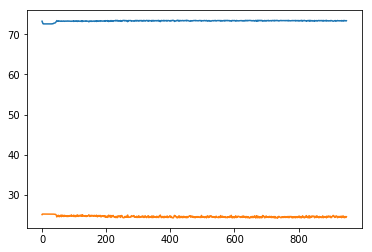

In [20]:
plt.plot(dis_loss),plt.plot(dis_acc)

([<matplotlib.lines.Line2D at 0x7f3c682f3940>],
 [<matplotlib.lines.Line2D at 0x7f3c682f3dd8>])

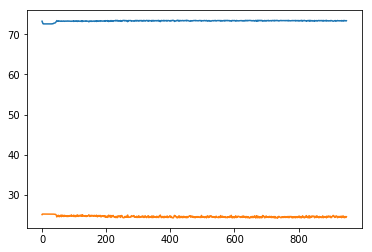

In [21]:
plt.plot(dis_loss),plt.plot(dis_acc)

([<matplotlib.lines.Line2D at 0x7efaf40cc6d8>],
 [<matplotlib.lines.Line2D at 0x7efaf40ccb70>])

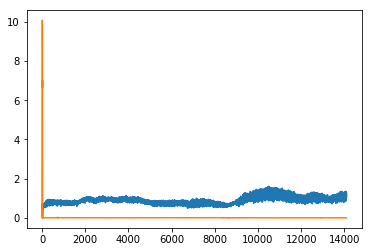

In [45]:
plt.plot(dis_loss),plt.plot(gen_loss)

([<matplotlib.lines.Line2D at 0x7efaae6dd780>],
 [<matplotlib.lines.Line2D at 0x7efaae6ddc18>])

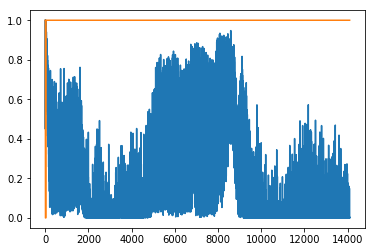

In [46]:
plt.plot(dis_acc),plt.plot(gen_acc)

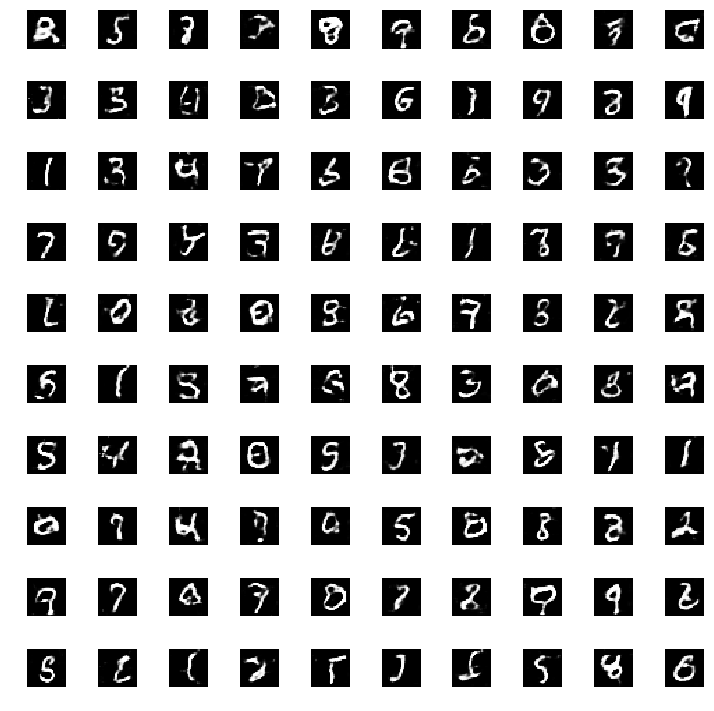

In [22]:
plot_output()

In [20]:
gen.save("./lol.h5")

In [31]:
ok=np.array((gen_acc,dis_acc,gen_loss,dis_loss))

In [35]:
np.save("losses_array_gendisacc_gendisloss.npy",ok)